In [2]:
ROOT_PATH = '../../../../'
# UKBB_DATA_PATH = ROOT_PATH + 'assets/data/ukbb/'
BASE_LOG_PATH = ROOT_PATH + 'medical_mesh_experiments/SVIExperiment'
# FIGURE_SAVE_PATH = 'figures'

In [3]:
import sys
import os

sys.path.append(ROOT_PATH)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

from tqdm import tqdm, trange

import traceback
import warnings
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
%matplotlib inline
import inspect
from collections import OrderedDict
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import torch
import seaborn as sns

torch.autograd.set_grad_enabled(False);

import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')

import pyvista as pv
pv.set_plot_theme("document")

# from coma.utils.visualise import plot_mesh_pyvista, plot_meshes_pyvista

In [5]:
# from coma.datasets.ukbb_meshdata import UKBBMeshDataset, VerticesDataLoader
# from coma.utils import transforms

# # Preprocessor
# preprocessor = transforms.get_transforms()

# brain_substructure = 'R_Hipp'

# # Load Dataset
# mesh_path = "/vol/biomedic3/bglocker/brainshapes"
# cache_path = "/vol/bitbucket/rrr2417/deepscm_data_cache"
# csv_path = "/vol/biomedic3/bglocker/brainshapes/ukb21079_extracted.csv"
# split = 0.8

# substructure_to_udi = {
#     'BrStem': '25025-2.0', 
#     'L_Thal': '25011-2.0',
#     'L_Caud': '25013-2.0',
#     'L_Puta': '25015-2.0',
#     'L_Pall': '25017-2.0',
#     'L_Hipp': '25019-2.0',
#     'L_Amyg': '25021-2.0',
#     'L_Accu': '25023-2.0',
#     'R_Thal': '25012-2.0',
#     'R_Caud': '25014-2.0',
#     'R_Puta': '25016-2.0',
#     'R_Pall': '25018-2.0',
#     'R_Hipp': '25020-2.0',
#     'R_Amyg': '25022-2.0',
#     'R_Accu': '25024-2.0',
# }

# feature_name_map = {
#     '31-0.0': 'sex',
#     '21003-0.0': 'age',
#     substructure_to_udi[brain_substructure]: 'structure_volume',  # Brain Stem
#     '25010-2.0': 'brain_volume',  # Unnormalised brain volume from UKBB
# }

# metadata_df = pd.read_csv(csv_path)

# total_train_dataset = UKBBMeshDataset(
#     mesh_path,
#     substructures=[brain_substructure],
#     split=split,
#     train=True,
#     transform=preprocessor,
#     reload_path=True,
#     features_df=metadata_df,
#     feature_name_map=feature_name_map,
#     cache_path=cache_path,
# )

# val_split = 0.1
# total_train_length = len(total_train_dataset)
# val_length = int(val_split * total_train_length)
# train_length = total_train_length - val_length

# train_dataset, val_dataset = torch.utils.data.random_split(
#     total_train_dataset,
#     lengths=[train_length, val_length],
#     generator=torch.Generator().manual_seed(42),
# )

# data = [train_dataset[i] for i in range(len(train_dataset))]
# meshes = torch.cat([mesh for (mesh, _) in data], 0).detach().numpy()
# print(meshes.shape)
# metadata_df = pd.concat([df for (_, df) in data], 0)
# print(metadata_df.shape)
# metadata_df.head()
# torch.save(meshes, 'training_hipp_meshes.pt')
# metadata_df.to_csv('training_hipp_metadata.csv')

# metadata_df = pd.read_csv(csv_path)
# total_test_dataset = UKBBMeshDataset(
#     mesh_path,
#     substructures=[brain_substructure],
#     split=split,
#     train=False,
#     transform=preprocessor,
#     reload_path=True,
#     features_df=metadata_df,
#     feature_name_map=feature_name_map,
#     cache_path=cache_path,
# )
# data = [total_test_dataset[i] for i in range(len(total_test_dataset))]
# meshes = torch.cat([mesh for (mesh, _) in data], 0).detach().numpy()
# print(meshes.shape)
# metadata_df = pd.concat([df for (_, df) in data], 0)
# print(metadata_df.shape)
# metadata_df.head()
# torch.save(meshes, 'testing_hipp_meshes.pt')
# metadata_df.to_csv('testing_hipp_metadata.csv')

In [6]:
test_stem_meshes = torch.load('testing_meshes.pt')
test_stem_metadata_df = pd.read_csv('testing_metadata.csv')
print(test_stem_metadata_df.head())

train_stem_metadata_df = pd.read_csv('training_metadata.csv')
train_stem_meshes = torch.load('training_meshes.pt')
print(train_stem_metadata_df.head())

   Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        4804  5026976    0   58             23486       1073400
1        3178  5027256    1   60             25223       1282190
2        4669  5027577    0   65             24819       1097400
3         845  5027876    0   56             21884       1093200
4        4457  5028604    1   62             24066       1191110
   Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        8809  3820915    0   56             23764       1041180
1       11675  3677460    1   66             22000       1143400
2        9633  4383421    1   63             27148       1369520
3        8374  3069151    0   59             20223        980627
4       14213  1457636    0   50             21183       1386220


In [7]:
test_hipp_meshes = torch.load('testing_hipp_meshes.pt')
test_hipp_metadata_df = pd.read_csv('testing_hipp_metadata.csv')
print(test_hipp_metadata_df.head())

train_hipp_metadata_df = pd.read_csv('training_hipp_metadata.csv')
train_hipp_meshes = torch.load('training_hipp_meshes.pt')
print(train_hipp_metadata_df.head())

   Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        4804  5026976    0   58              3856       1073400
1        3178  5027256    1   60              4478       1282190
2        4669  5027577    0   65              3805       1097400
3         845  5027876    0   56              3900       1093200
4        4457  5028604    1   62              3911       1191110
   Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        8809  3820915    0   56              3690       1041180
1       11675  3677460    1   66              3910       1143400
2        9633  4383421    1   63              5041       1369520
3        8374  3069151    0   59              3396        980627
4       14213  1457636    0   50              4393       1386220


In [8]:
template_path = '/vol/biomedic3/bglocker/brainshapes/5026976'
stem_name = 'T1_first-BrStem_first.vtk'
hipp_name = 'T1_first-R_Hipp_first.vtk'
stem_template = pv.read(f'{template_path}/{stem_name}')
hipp_template = pv.read(f'{template_path}/{hipp_name}')

## Load Model 

In [9]:
from deepscm.experiments.medical_meshes import ukbb  # noqa: F401
from deepscm.experiments.medical_meshes.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [10]:
def load_model(base_log_path, exp='ConditionalVISEM', version='version_87'):
    checkpoint_path = f'{base_log_path}/{exp}/{version}/'
    base_path = os.path.join(checkpoint_path, 'checkpoints')
    checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

    ckpt = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    hparams = ckpt['hyper_parameters']

    model_class = MODEL_REGISTRY[hparams['model']]

    model_params = {
        k: v for k, v in hparams.items() if (
            k in inspect.signature(model_class.__init__).parameters
            or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
            or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters
        )
    }
    model_params['gpu'] = 0

    new_state_dict = OrderedDict()

    for key, value in ckpt['state_dict'].items():
        new_key = key.replace('pyro_model.', '')
        new_state_dict[new_key] = value

    loaded_model = model_class(**model_params)
    loaded_model.load_state_dict(new_state_dict)

    for p in loaded_model._buffers.keys():
        if 'norm' in p:
            setattr(loaded_model, p, getattr(loaded_model, p))

    loaded_model.eval()
    # loaded_models[exp] = loaded_model

    def sample_pgm(num_samples, model):
        with pyro.plate('observations', num_samples):
            return model.pgm_model()

    model = partial(sample_pgm, model=loaded_model)
    
    return loaded_model, model

In [145]:
exp = 'ConditionalVISEM'

brainstem_model_nos = [87, 96, 95, 99]
brainstem_loaded_models = {
    no: load_model(BASE_LOG_PATH, exp, f'version_{no}')[0]
    for no in brainstem_model_nos
}
brainstem_models = {
    no: load_model(BASE_LOG_PATH, exp, f'version_{no}')[1]
    for no in brainstem_model_nos
}

hipp_model_nos = [90, 94, 97, 101]
hipp_loaded_models = {
    no: load_model(BASE_LOG_PATH, exp, f'version_{no}')[0]
    for no in hipp_model_nos
}
hipp_models = {
    no: load_model(BASE_LOG_PATH, exp, f'version_{no}')[1]
    for no in hipp_model_nos
}

(642, 3)
(642, 3)
(642, 3)
(642, 3)
(642, 3)
(642, 3)
(642, 3)
(642, 3)
(664, 3)
(664, 3)
(664, 3)
(664, 3)
(664, 3)
(664, 3)
(664, 3)
(664, 3)


In [156]:
from tensorboard.backend.event_processing import event_accumulator

def load_scalars(path):
    """
    https://stackoverflow.com/questions/52756152/tensorboard-extract-scalar-by-a-script
    """
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}

    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []

        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)

        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [168]:
path = f'{BASE_LOG_PATH}/{exp}/version_'

metrics = [
    'epoch', 'train/log p(age)', 'train/log p(brain_volume)', 'train/log p(sex)', 
    'train/log p(structure_volume)', 'train/log p(x)', 'train/loss',
    'val/log p(age)', 'val/log p(brain_volume)', 'val/log p(sex)',
    'val/log p(structure_volume)', 'val/log p(x)', 'val/loss'
]  
metrics_df = pd.DataFrame(columns=['model no'] + metrics)

for no in brainstem_model_nos:
    folder = path + str(no)
    scalars = load_scalars(f'{path}{no}')
    metrics_list = [no]
    for metric in metrics:
        metrics_list.append(scalars[metric][1][-1])
    _series = pd.Series(metrics_list, index=metrics_df.columns)
    metrics_df = metrics_df.append(_series, ignore_index=True)

In [169]:
metrics_df.head()

model no  epoch  train/log p(age)  train/log p(brain_volume)  \
0      87.0  237.0         -3.375252                 -12.680288   
1      96.0  192.0         -3.755893                 -12.762418   
2      95.0   43.0         -3.188467                 -13.303553   
3      99.0  103.0         -3.171539                 -13.321387   

   train/log p(sex)  train/log p(structure_volume)  train/log p(x)  \
0         -0.693434                      -8.752459    28723.732422   
1         -0.693845                      -9.513501    35447.984375   
2         -0.693848                      -8.876898    35681.957031   
3         -0.693848                      -8.852541    42481.714844   

     train/loss  val/log p(age)  val/log p(brain_volume)  val/log p(sex)  \
0 -286537.78125       -3.365363               -12.824821       -0.693307   
1 -353273.09375       -3.363797               -12.824802       -0.693307   
2 -355039.90625       -3.364605               -12.827953       -0.693307   
3 -421445.87500       -3.344852               -12.824467       -0.693307   

   val/log p(structure_volume)  val/log p(x)    val/loss  
0                    -9.038745  126095.21875  -6370000.0  
1                    -9.035712  215883.56250 -10736842.0  
2                    -9.039389  224595.18750 -11161063.0  
3                    -9.036235  270227.03125 -13429944.0

In [216]:
from pytorch3d.loss import chamfer_distance

In [ ]:
# MSE + MAE
batch_size = 100
recon_metrics = {
    no: {'mse': None, 'mae': None, 'chamfer': None}
    for no in brainstem_model_nos
}

for no in brainstem_model_nos:
    print(no)
    recons = []
    for i in range((test_stem_meshes.shape[0] // batch_size) + 1):
        lb = i * batch_size
        ub = min(i * batch_size + batch_size, test_stem_meshes.shape[0])
        mesh = torch.tensor(test_stem_meshes[lb:ub]).float()
        # print(mesh.shape)
        age = torch.tensor(test_stem_metadata_df.age.values[lb:ub]).unsqueeze(1).float()
        # print(age.shape)
        sex = torch.tensor(test_stem_metadata_df.sex.values[lb:ub]).unsqueeze(1).float()
        # print(sex.shape)
        structure_volume = torch.tensor(test_stem_metadata_df.structure_volume.values[lb:ub]).unsqueeze(1).float()
        # print(structure_volume.shape)
        brain_volume = torch.tensor(test_stem_metadata_df.brain_volume.values[lb:ub]).unsqueeze(1).float()
        # print(brain_volume.shape)
        recon = brainstem_loaded_models[no].reconstruct(mesh, age, sex, structure_volume, brain_volume)
        recons.append(recon)
        # if i == 1:
        #    break
        # print(recon.shape)
    recon = torch.cat(recons)
    recon_metrics[no]['mse'] = torch.nn.functional.mse_loss(recon, test_stem_meshes)
    recon_metrics[no]['mae'] = torch.nn.functional.l1_loss(recon, test_stem_meshes)
    recon_metrics[no]['chamfer'] = chamfer_distance(recon, test_stem_meshes)[0]
    print(recon_metrics[no])

87


In [84]:
# brain vol vs structure vol

# hipp_samples = models[99](10000)
# a, s, v, b = np.stack([var.int().numpy() for var in brainstem_samples])
# a[:5], s[:5], v[:5], b[:5]

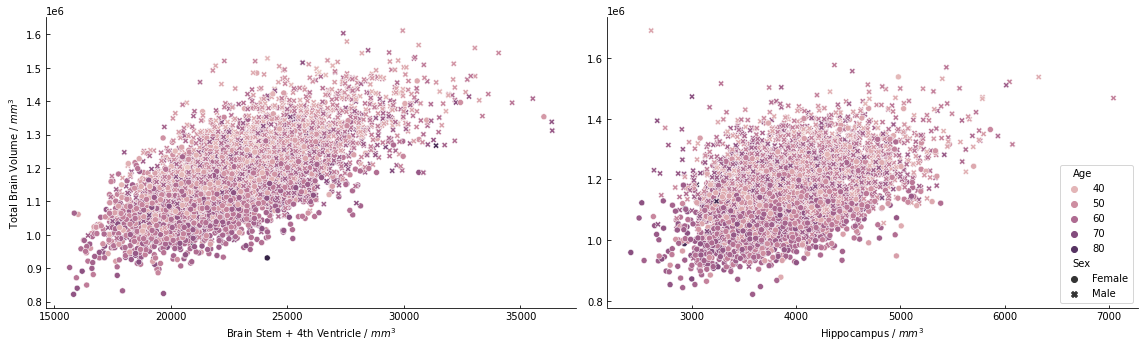

In [102]:
width = 16
height = width / (1.618 * 2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(width, height))

n_samples = 5000

_brainstem_samples = brainstem_models[brainstem_model_nos[0]](n_samples)
_hipp_samples = hipp_models[hipp_model_nos[0]](n_samples)

brainstem_samples = np.stack([var.int().numpy().flatten() for var in _brainstem_samples])

columns = [
    'Age',
    'Sex',
    'Brain Stem + 4th Ventricle / $mm^3$',
    'Total Brain Volume / $mm^3$'
]
df = pd.DataFrame(brainstem_samples.T, columns=columns)
df.replace({'Sex': {0: 'Female', 1: 'Male'}}, inplace=True)
ax = sns.scatterplot(data=df, x=columns[2], y=columns[3], hue=columns[0], style=columns[1], ax=axes[0])
ax.get_legend().remove()
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='x', direction='in')

columns = [
    'Age',
    'Sex',
    'Hippocampus / $mm^3$',
    'Total Brain Volume / $mm^3$'
]
hipp_samples = np.stack([var.int().numpy().flatten() for var in _hipp_samples])
df = pd.DataFrame(hipp_samples.T, columns=columns)
df.replace({'Sex': {0: 'Female', 1: 'Male'}}, inplace=True)
ax = sns.scatterplot(data=df, x=columns[2], y=columns[3], hue=columns[0], style=columns[1], ax=axes[1])
ax.set(ylabel=None)
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='x', direction='in')

sns.despine()
plt.tight_layout()
# plt.savefig('total_to_subcortial_pairplot_2.png', dpi=300)
plt.show()

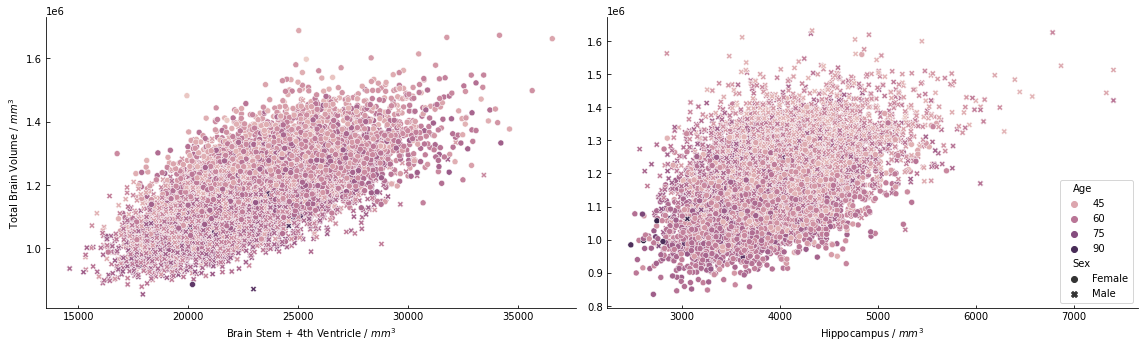

In [107]:
width = 16
height = width / (1.618 * 2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(width, height))

n_samples = 10000

_brainstem_samples = brainstem_models[brainstem_model_nos[-1]](n_samples)
_hipp_samples = hipp_models[hipp_model_nos[-1]](n_samples)

brainstem_samples = np.stack([var.int().numpy().flatten() for var in _brainstem_samples])

columns = [
    'Age',
    'Sex',
    'Brain Stem + 4th Ventricle / $mm^3$',
    'Total Brain Volume / $mm^3$'
]
df = pd.DataFrame(brainstem_samples.T, columns=columns)
df.replace({'Sex': {0: 'Female', 1: 'Male'}}, inplace=True)
ax = sns.scatterplot(data=df, x=columns[2], y=columns[3], hue=columns[0], style=columns[1], ax=axes[0])
ax.get_legend().remove()
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='x', direction='in')

columns = [
    'Age',
    'Sex',
    'Hippocampus / $mm^3$',
    'Total Brain Volume / $mm^3$'
]
hipp_samples = np.stack([var.int().numpy().flatten() for var in _hipp_samples])
df = pd.DataFrame(hipp_samples.T, columns=columns)
df.replace({'Sex': {0: 'Female', 1: 'Male'}}, inplace=True)
ax = sns.scatterplot(data=df, x=columns[2], y=columns[3], hue=columns[0], style=columns[1], ax=axes[1])
ax.set(ylabel=None)
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='x', direction='in')

sns.despine()
plt.tight_layout()
# plt.savefig('total_to_subcortial_pairplot_2.png', dpi=300)
plt.show()

## Conditional Samples

In [58]:
model = loaded_models[exp]

b_range = [800000., 1200000., 1600000.]
v_range = [10000., 28000., 40000.]

samples = {
    'x': [],
    'brain_volume': [],
    'structure_volume': [],

}

save_name = f'{exp}_cond_samples'

# for _ in range(num_ex):
z = model.sample(1)[1]

for i, brain_volume in enumerate(b_range):
    for j, structure_volume in enumerate(v_range):
        brain_volume = torch.tensor([[brain_volume]])
        structure_volume = torch.tensor([[structure_volume]])
        data = {
            'z': z,
            'brain_volume': brain_volume,
            'structure_volume': structure_volume,
        }
        
        x, *_ = pyro.condition(loaded_models[exp].sample, data=data)(1)
        template_copy = template.copy()
        template_copy.points = x[0].numpy()
        samples['x'] += [template_copy]
        samples['brain_volume'] += [brain_volume]
        samples['structure_volume'] += [structure_volume]

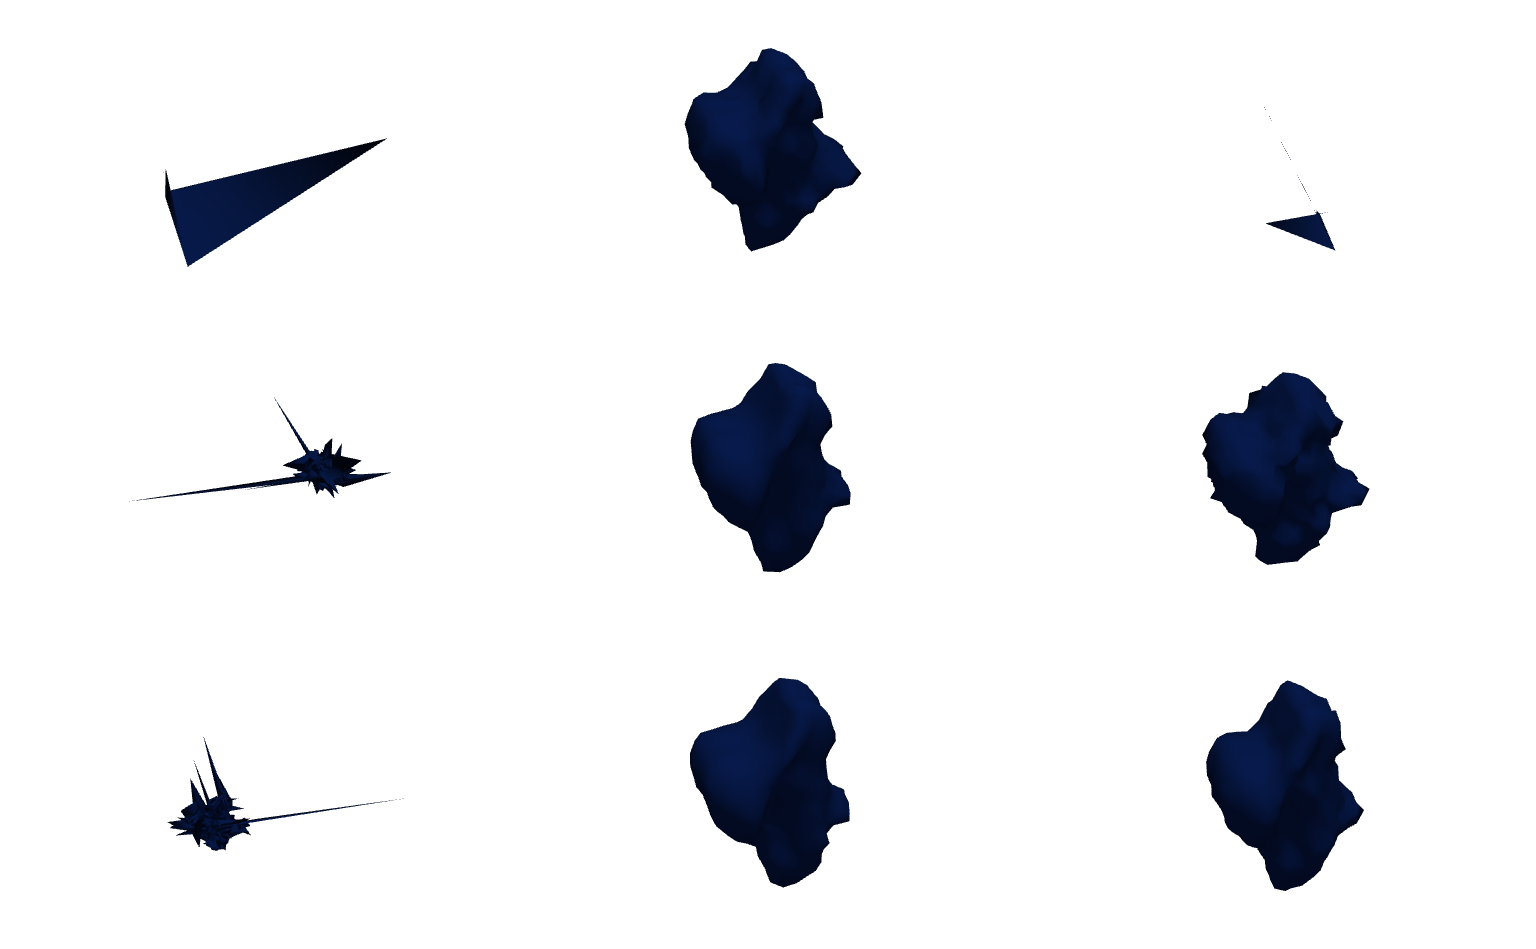

[(124.1944237236261, -20.320286702704465, 147.16279702227112),
 (31.99851703643799, -112.51619338989258, 54.96689033508301),
 (0.0, 0.0, 1.0)]

In [60]:
width = 768 * 2
height = int(width / (1.618))

rotations = [(0, 0, 240)]

plotter = pv.Plotter(
    shape=(len(b_range), len(v_range)),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)

plot_meshes_pyvista(
    plotter,
    samples['x'],  # polydatas,
    rotations=rotations * len(b_range) * len(v_range),
    vertexcolors=np.ones((9, 642, 3)) * 100,
    vertexscalar='distance',
    scalar_bar_idx=None, # len(b_range) * len(v_range) - 1,
    titles=[''] * len(b_range) * len(v_range), # [f'Mode {x - 1}' for x in modes] + [''] * n_modes * (n_laps - 1),
    mesh_kwargs=dict(
        smooth_shading=True
    ),
    scalar_bar_kwargs=dict(
        label_font_size=10,
        position_x=0.85,
        title_font_size=10,
        shadow=True,
        n_labels=2,
        fmt='%.2f',
    ),
)

plotter.show(screenshot='conditional_brain_stem_samples.png')

## Reconstructions

## Counterfactuals

In [75]:
var_name = {
    'structure_volume': 'v',
    'brain_volume': 'b',
    'sex': 's',
    'age': 'a',
}
value_fmt = {
    'structure_volume': lambda s: f'{np.round(float(s)/1000, 4)}ml',
    'brain_volume': lambda s: f'{np.round(float(s)/1000, 4)}ml',  # rf'{float(s)/1000:.4g}\,\mathrm{{ml}}',
    'age': lambda s: f'{int(s)}y',   # rf'{int(s):d}\,\mathrm{{y}}',
    'sex': lambda s: '{}'.format(['female', 'male'][int(s)])
}

def fmt_intervention(intervention):
    if isinstance(intervention, str):
        var, value = intervention[3:-1].split('=')
        return f"$do({var_name[var]}={value_fmt[var](value)})$"
    else:
        intervention_strs = [
            f'{var_name[k]}={value_fmt[k](v)}'
            for k, v in intervention.items()
        ]
        all_interventions = ', '.join(intervention_strs)
        return f"do({all_interventions})"

def prep_data(input_dict):
    x = torch.tensor(input_dict['x']).unsqueeze(0).float()
    age = torch.tensor([[input_dict['age']]]).float()
    sex = torch.tensor([[input_dict['sex']]]).float()
    structure_volume = torch.tensor([[input_dict['structure_volume']]]).float()
    brain_volume = torch.tensor([[input_dict['brain_volume']]]).float()

    return {
        'x': x,
        'age': age,
        'sex': sex,
        'structure_volume': structure_volume,
        'brain_volume': brain_volume
    }

def get_inputs_for_counterfactuals(metadata_df, meshes, age_sex_samples):
    all_inputs = []
    eids = []
    
    for age, sex in age_sex_samples:
        mask = (metadata_df.age == age) & (metadata_df.sex == sex)

        row = metadata_df[mask].head(1)
        eid = row.eid.values[0]
        brain_volume = row.brain_volume.values[0]
        structure_volume = row.structure_volume.values[0]
        x = meshes[mask][0]

        input_dict = {
            'x': x,
            'age': age,
            'sex': sex,
            'brain_volume': brain_volume,
            'structure_volume': structure_volume
        }
        all_inputs.append(input_dict)
        eids.append(eid)
        
    return all_inputs, eids

def get_counterfactuals(age_sex_samples, all_inputs, all_interventions, model, num_samples=1):
    counterfactuals = {}

    for (age, sex), orig_data, interventions in zip(age_sex_samples, all_inputs, all_interventions):
        imgs, diffs = [], []
        orig_data = prep_data(orig_data)

        for intervention in interventions:
            pyro.clear_param_store()

            cond = {k: torch.tensor([[v]]) for k, v in intervention.items()}
            counterfactual = model.counterfactual(
                orig_data, cond, num_samples
            )

            imgs += [counterfactual['x']]
            diffs += [(- orig_data['x'] + counterfactual['x']).squeeze().mean(axis=1)]

        counterfactuals[(age, sex)] = {'imgs': imgs, 'diffs': diffs}
    
    return counterfactuals

def plot_counterfactuals(age_sex_samples, eids, all_inputs, all_interventions, template, counterfactuals, clim):
    width = 768 * 2
    height = int(width / (1.618 * 2))

    rotations = [(0, 0, 240)]

    for age_sex, eid, orig_data, interventions in zip(age_sex_samples, eids, all_inputs, all_interventions):
        counterfactual = counterfactuals[age_sex]

        polydatas = [template]
        for img in counterfactual['imgs']:
            template_copy = template.copy()
            template_copy.points = img.squeeze(0).numpy()
            polydatas.append(template_copy)
        
        colors = np.concatenate(
            [np.zeros((1, template_copy.points.shape[0]))] +
            [np.expand_dims(diff, 0) for diff in counterfactual['diffs']]
        )
        age_title = f'{var_name["age"]}={value_fmt["age"](str(age_sex[0]))}' 
        sex_title = f'{var_name["sex"]}={value_fmt["sex"](str(age_sex[1]))}'
        titles = [f'{age_title}, {sex_title}']
        titles += [fmt_intervention(_intervention) for _intervention in interventions]

        plotter = pv.Plotter(
            shape=(1, len(polydatas)),
            window_size=(width, height),
            border=False,
            lighting='light_kit',
            off_screen=True,
            notebook=True,
        )

        plot_meshes_pyvista(
            plotter,
            polydatas,
            rotations=rotations * len(polydatas),
            vertexcolors=colors,
            vertexscalar='distance',
            scalar_bar_idx=len(polydatas) - 1,
            titles=titles,
            mesh_kwargs=dict(
                smooth_shading=True,
                cmap='seismic',
                clim=clim,
            ),
            scalar_bar_kwargs=dict(
                label_font_size=10,
                position_x=0.85,
                title_font_size=10,
                shadow=True,
                n_labels=2,
                fmt='%.2fmm',
            ),
            title_kwargs=dict(
                font_size=8,
            ),
        )
        plotter.show()  # screenshot='spectral_modes_brain_stem.png')

In [9]:
age_sex_samples = [
    (40, 1), (45, 1), (50, 1), (55, 1), (60, 1), (65, 1), (70, 1),
    (40, 0), (45, 0), (50, 0), (55, 0), (60, 0), (65, 0), (70, 0),
]
all_age_interventions = [[
    {'age': 35.},
#     {'age': 40.},
    {'age': 45.},
#     {'age': 50.},
    {'age': 55.},
#     {'age': 60.},
    {'age': 65.},
#     {'age': 70.},
    {'age': 75.},
#     {'age': 80.},
]] * len(age_sex_samples)
all_sex_interventions = [[{'sex': 0.}, {'sex': 1.}]] * len(age_sex_samples)

In [14]:
cfs = {
    'stem': {'training': {'age': None, 'sex': None}, 'testing': {'age': None, 'sex': None}},
    'hipp': {'training': {'age': None, 'sex': None}, 'testing': {'age': None, 'sex': None}},
}

### Brain Stem

#### Training data - Age interventions

In [45]:
# all_inputs, eids = get_inputs_for_counterfactuals(
#     train_stem_metadata_df, train_stem_meshes, age_sex_samples
# )
# counterfactuals = get_counterfactuals(
#     age_sex_samples, all_inputs, all_age_interventions, stem_loaded_model,
# )
# cfs['stem']['training']['age'] = counterfactuals

#### Training data - Sex interventions

In [31]:
# all_inputs, eids = get_inputs_for_counterfactuals(
#     train_stem_metadata_df, train_stem_meshes, age_sex_samples
# )
# counterfactuals = get_counterfactuals(
#     age_sex_samples, all_inputs, all_sex_interventions, stem_loaded_model,
# )
# cfs['stem']['training']['sex'] = counterfactuals

#### Test data - Age interventions

In [91]:
# all_inputs, eids = get_inputs_for_counterfactuals(
#     test_stem_metadata_df, test_stem_meshes, age_sex_samples
# )
# counterfactuals = get_counterfactuals(
#     age_sex_samples, all_inputs, all_age_interventions, stem_loaded_model,
# )
# cfs['stem']['testing']['age'] = counterfactuals
# plot_counterfactuals(
#     age_sex_samples, eids, all_inputs, all_age_interventions, stem_template, 
#     counterfactuals, [-2.0, 2.0],
# )

In [146]:
# model_nos = [87, 96, 95, 99]
# models = {
#     no: load_model(BASE_LOG_PATH, 'ConditionalVISEM', f'version_{no}')[0]
#     for no in model_nos
# }

# cfs = {}

# for no, model in models.items():
#     all_inputs, eids = get_inputs_for_counterfactuals(
#         test_stem_metadata_df, test_stem_meshes, age_sex_samples
#     )
#     counterfactuals = get_counterfactuals(
#         age_sex_samples, all_inputs, all_age_interventions, model,
#     )
#     cfs[no] = counterfactuals
    
# np.save('cfs_all_brain_stem', cfs)

(642, 3)
(642, 3)
(642, 3)
(642, 3)


#### Test data - Sex interventions

In [93]:
all_inputs, eids = get_inputs_for_counterfactuals(
    test_stem_metadata_df, test_stem_meshes, age_sex_samples
)
counterfactuals = get_counterfactuals(
    age_sex_samples, all_inputs, all_sex_interventions, stem_loaded_model,
)
# cfs['stem']['testing']['sex'] = counterfactuals

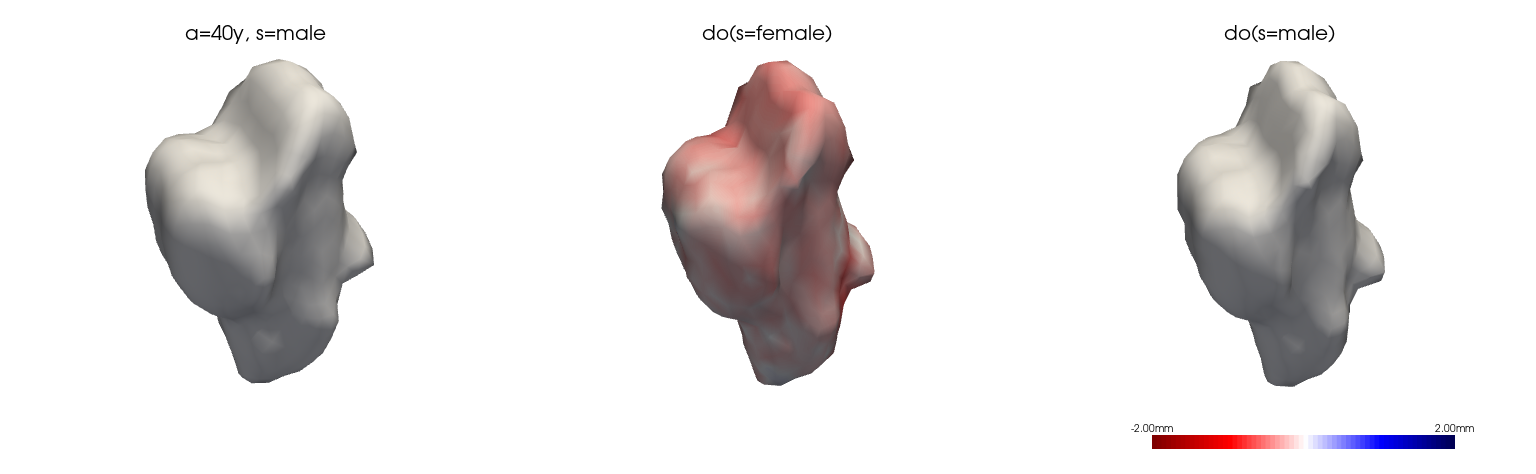

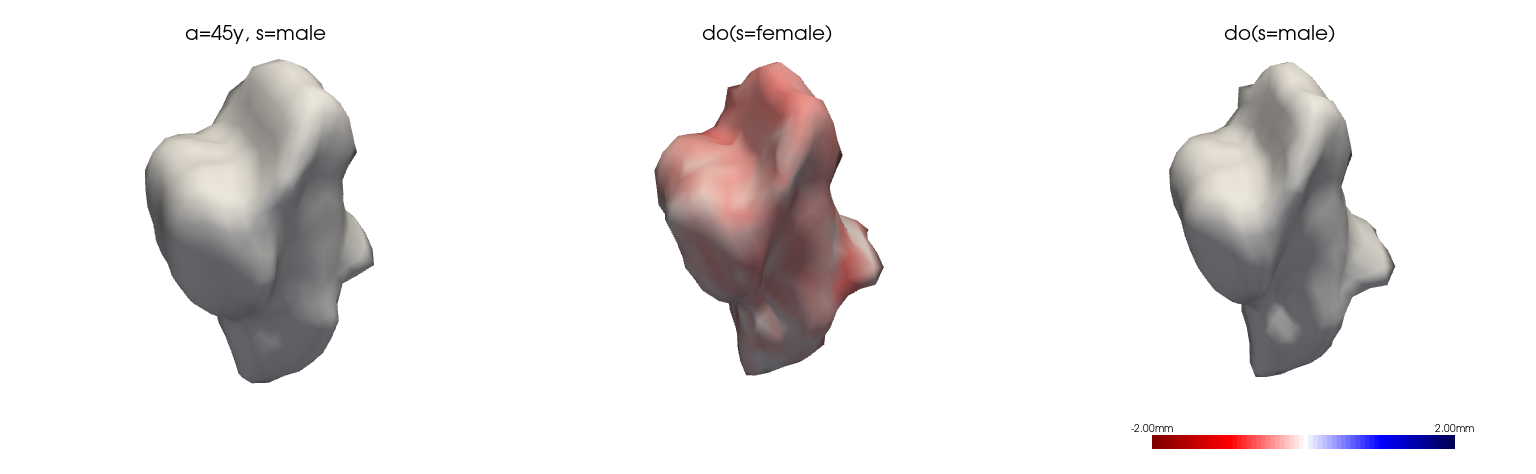

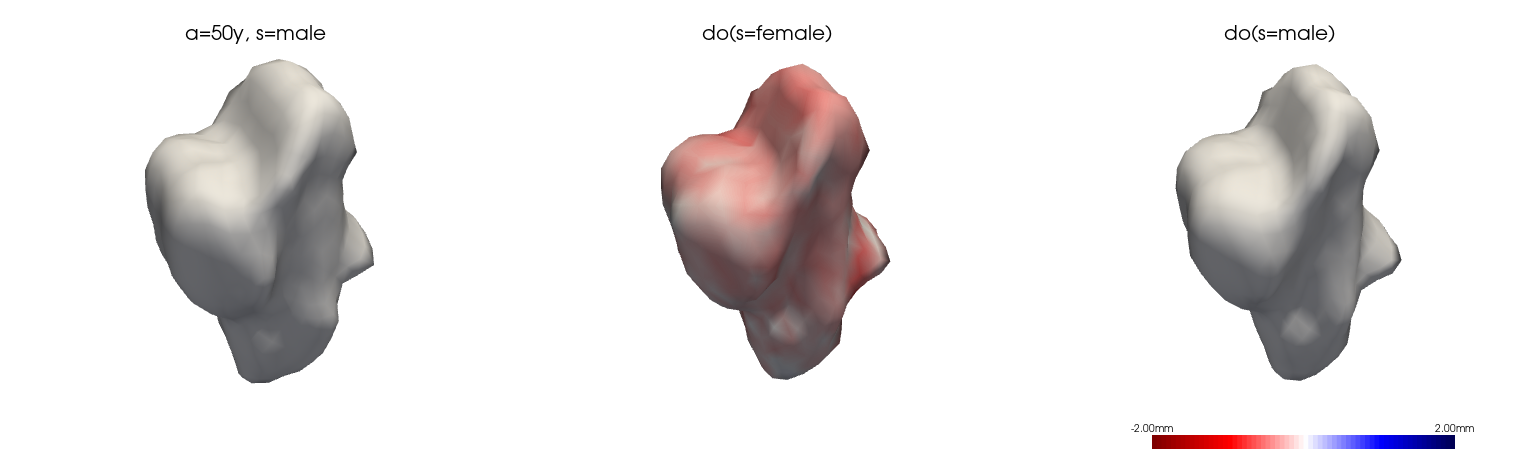

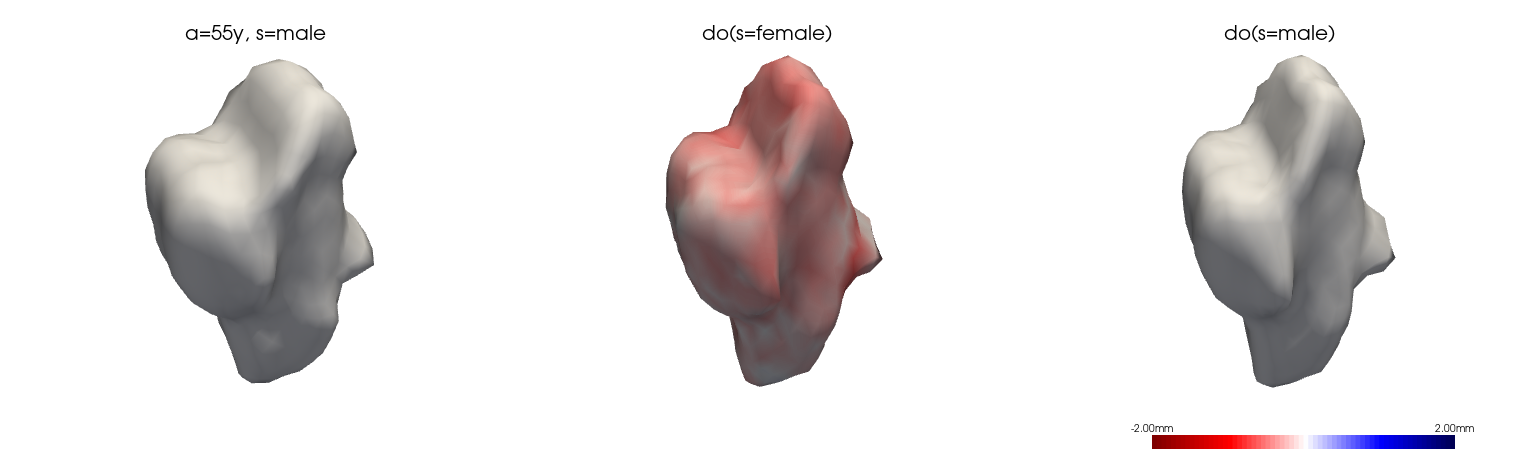

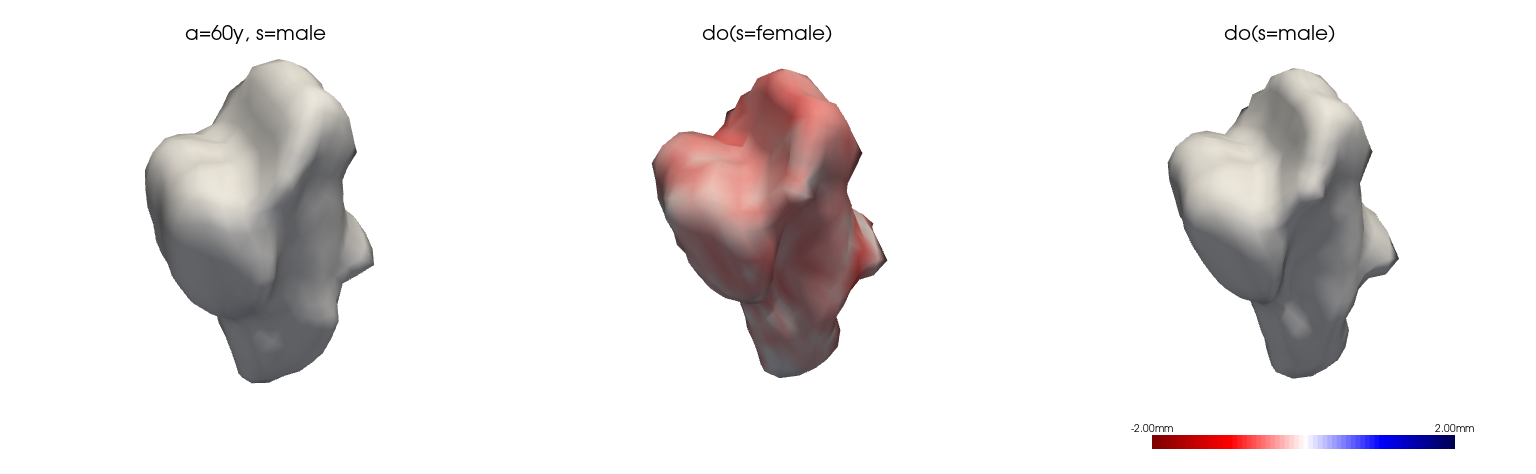

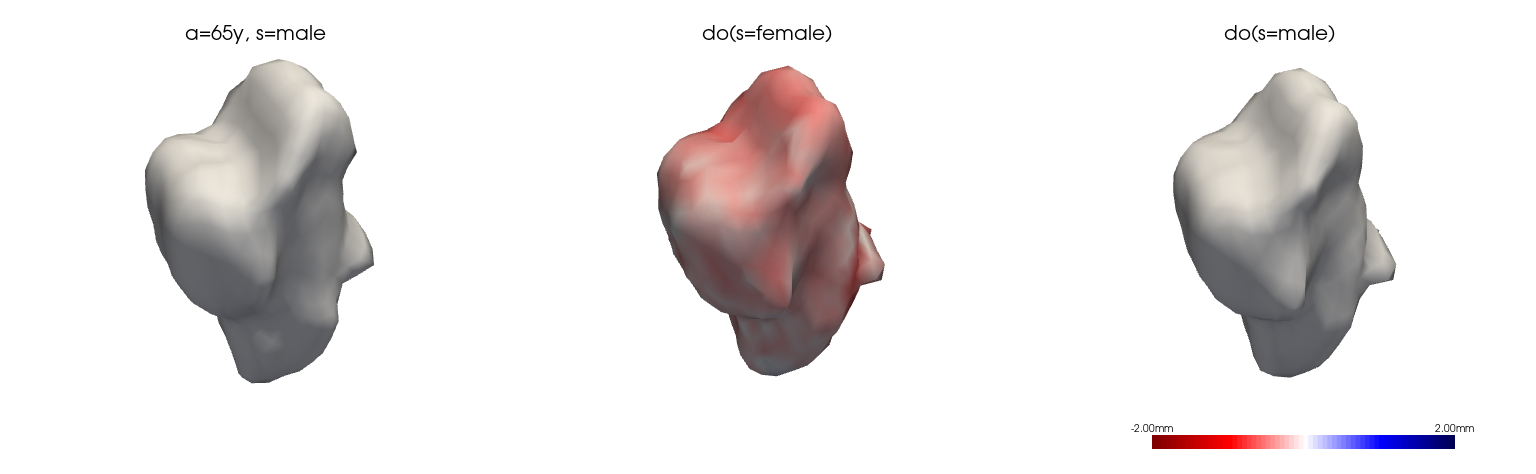

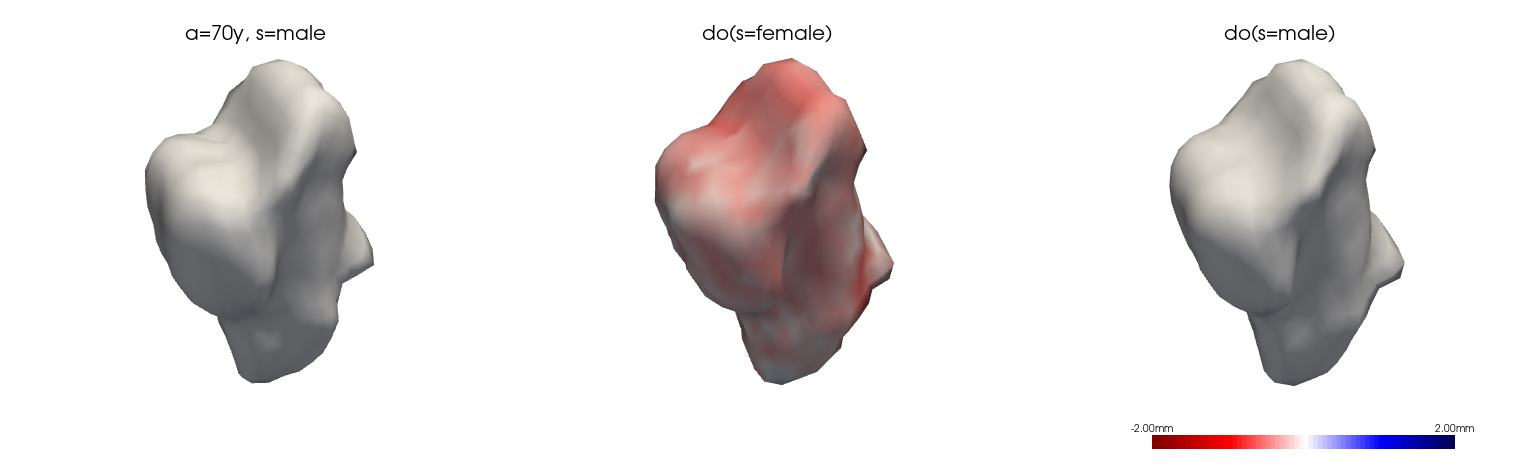

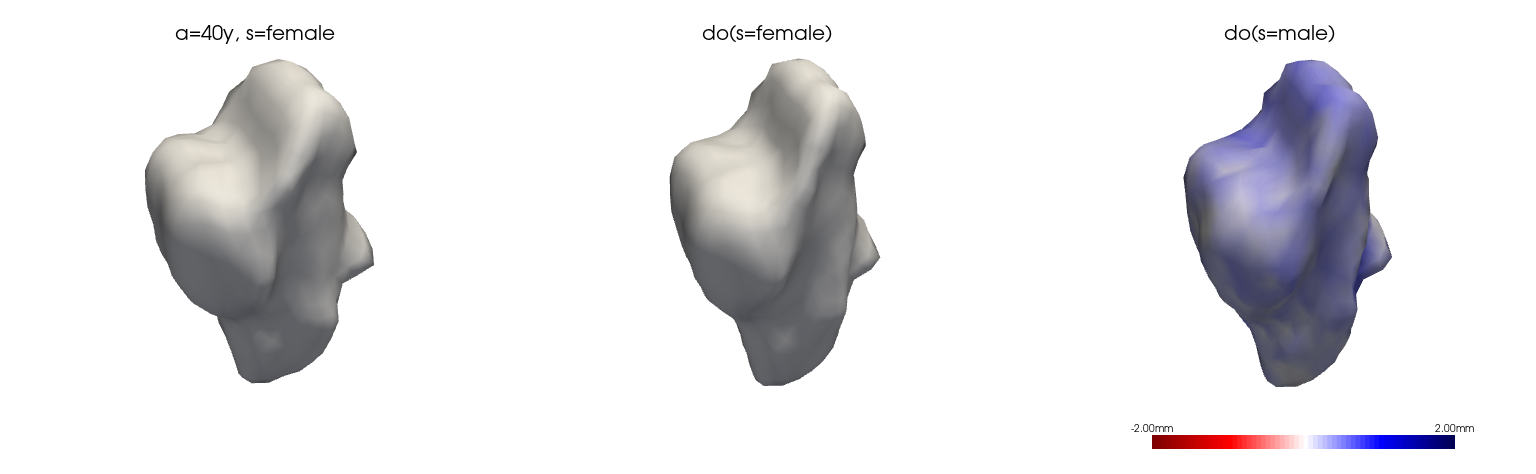

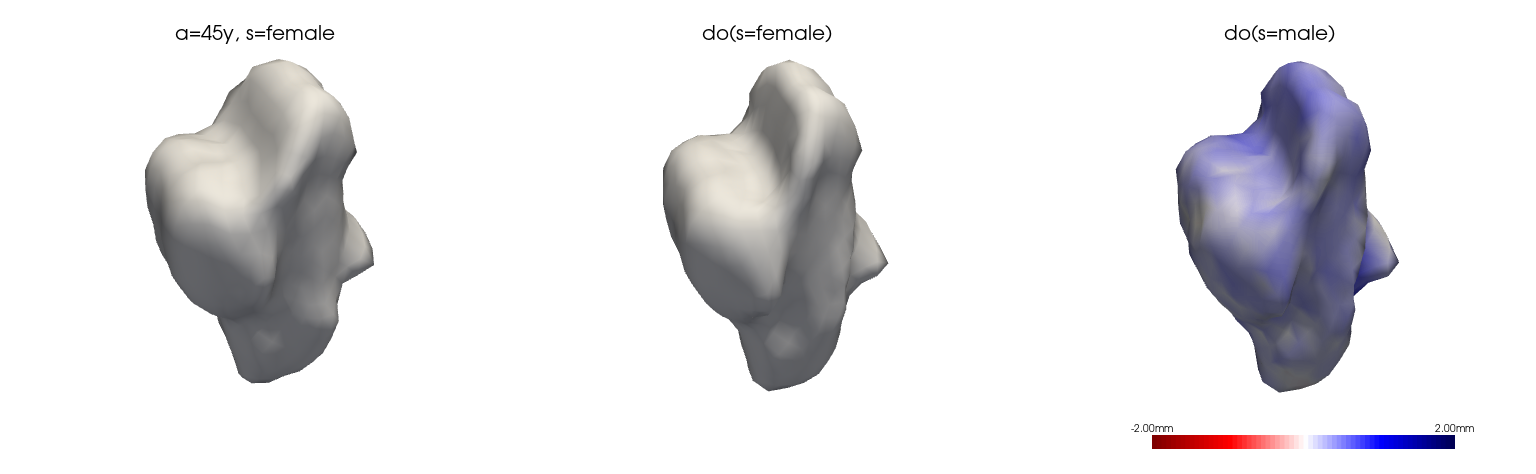

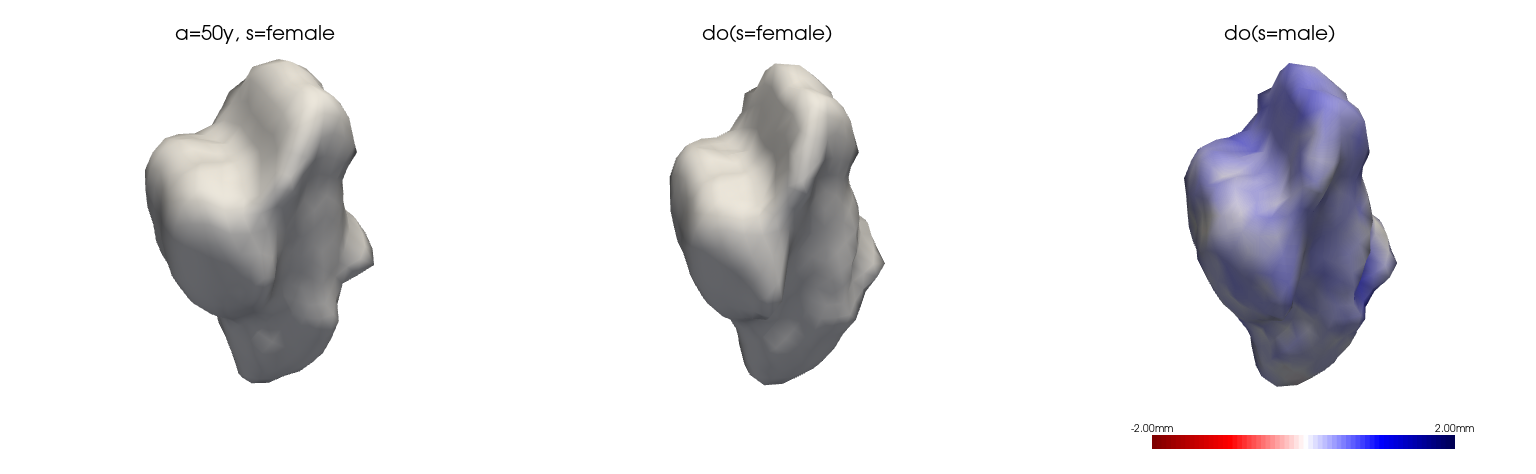

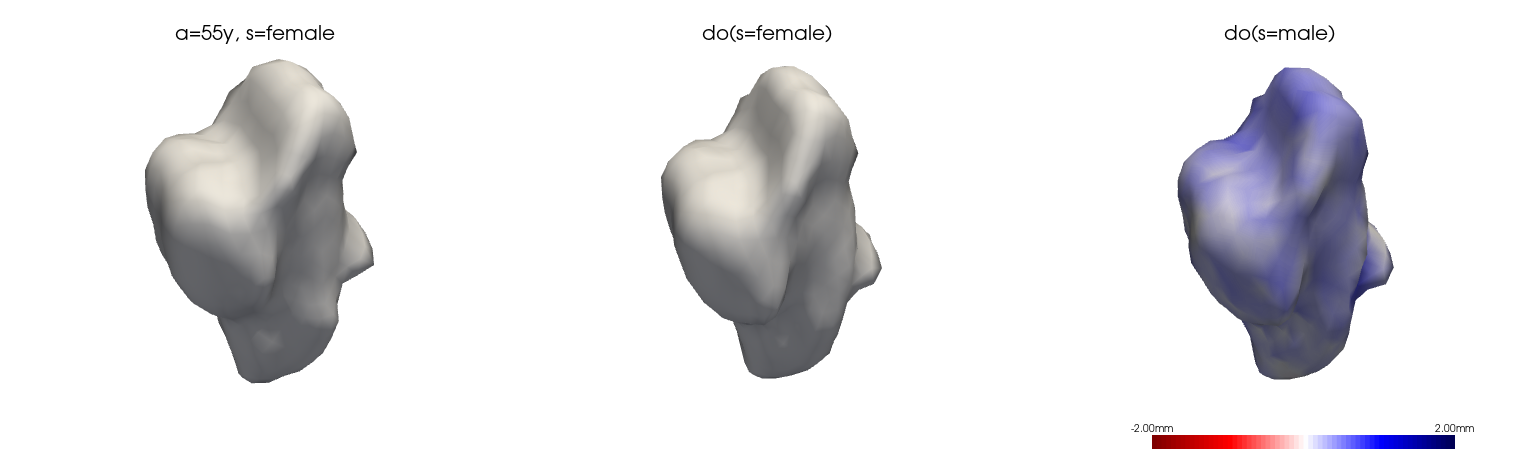

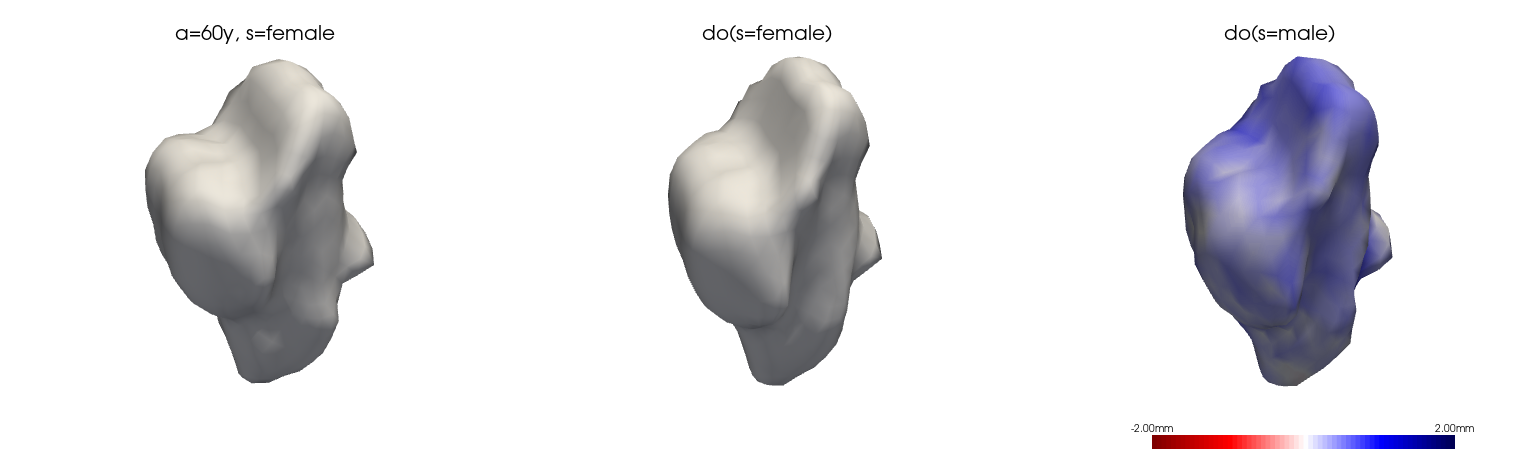

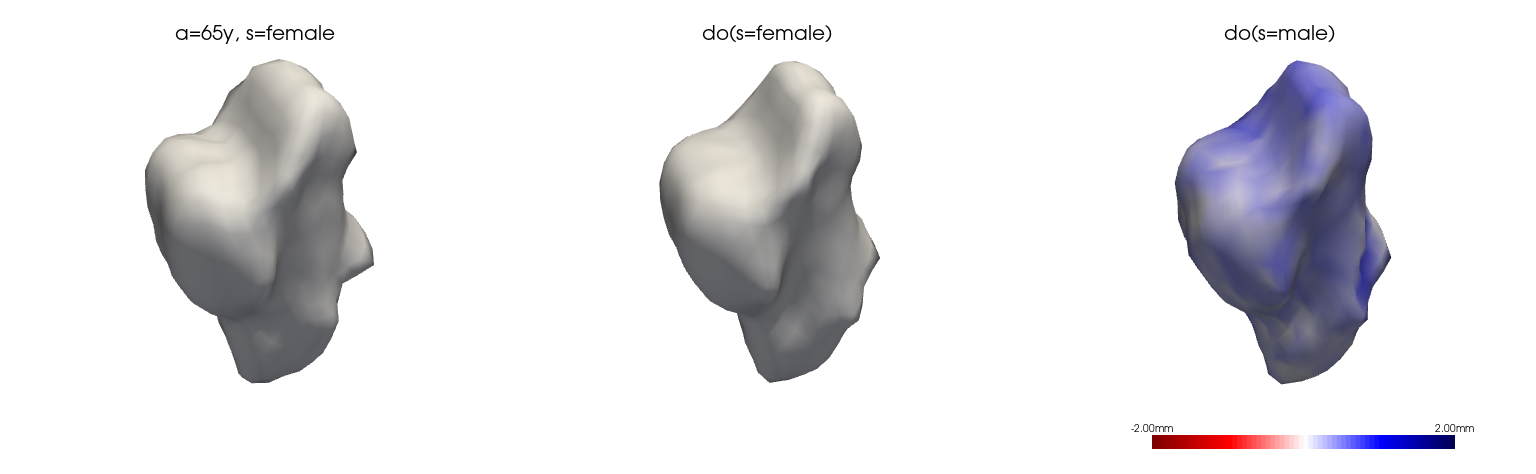

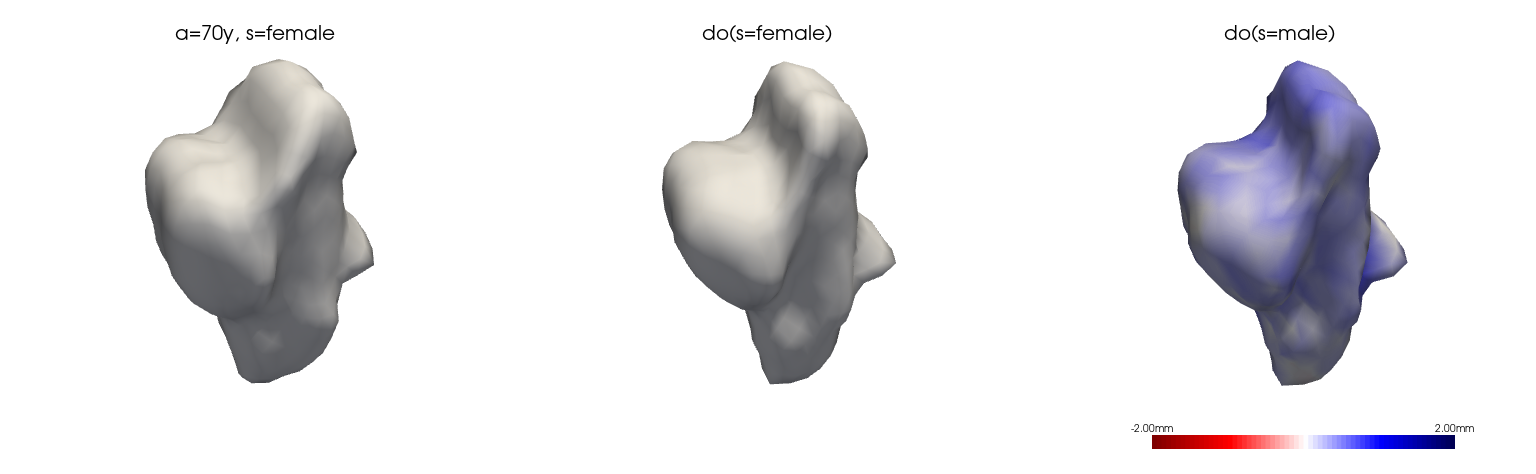

In [95]:
plot_counterfactuals(
    age_sex_samples, eids, all_inputs, all_sex_interventions, stem_template, 
    counterfactuals, [-2.0, 2.0],
)

### Hippocampus

In [87]:
all_inputs, eids = get_inputs_for_counterfactuals(
    train_hipp_metadata_df, train_hipp_meshes, age_sex_samples
)
counterfactuals = get_counterfactuals(
    age_sex_samples, all_inputs, all_age_interventions, hipp_loaded_model,
)
# cfs['hipp']['training']['age'] = counterfactuals

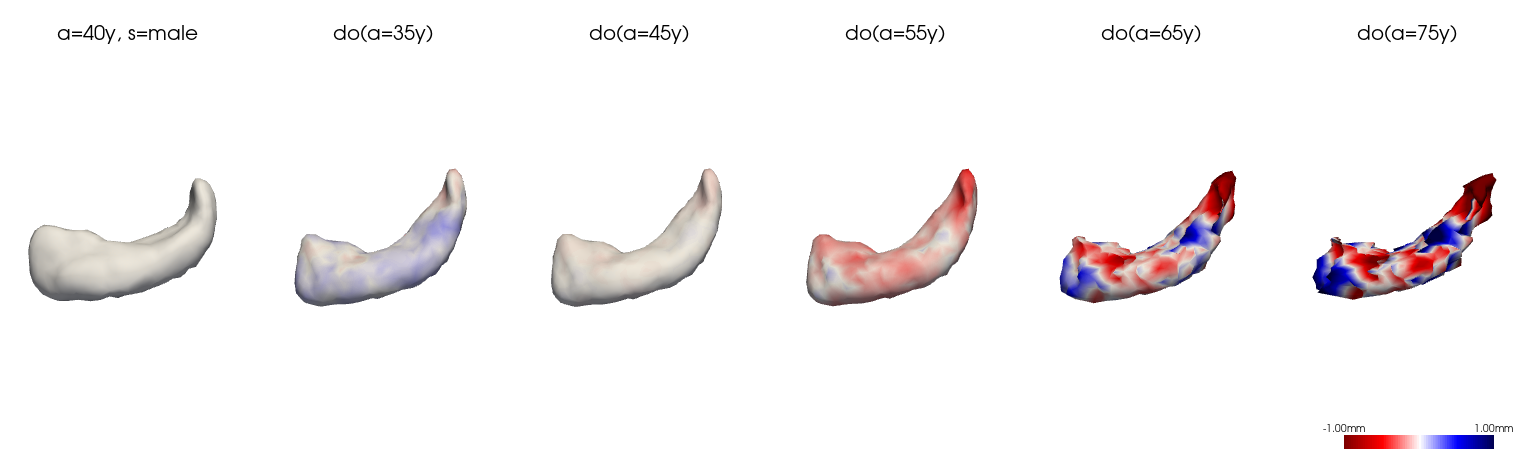

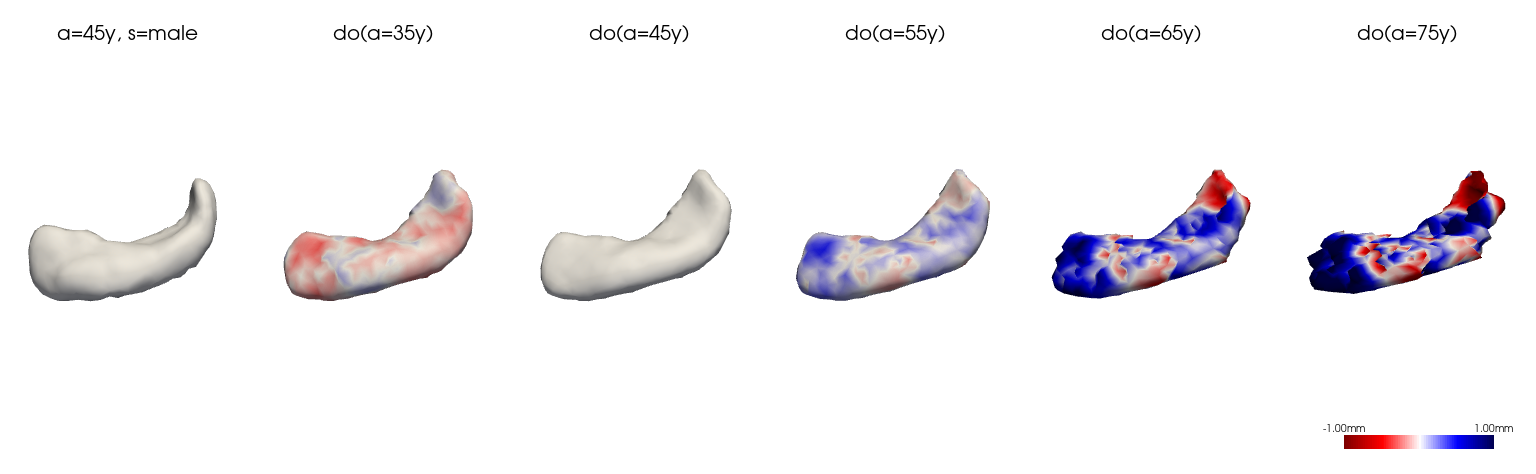

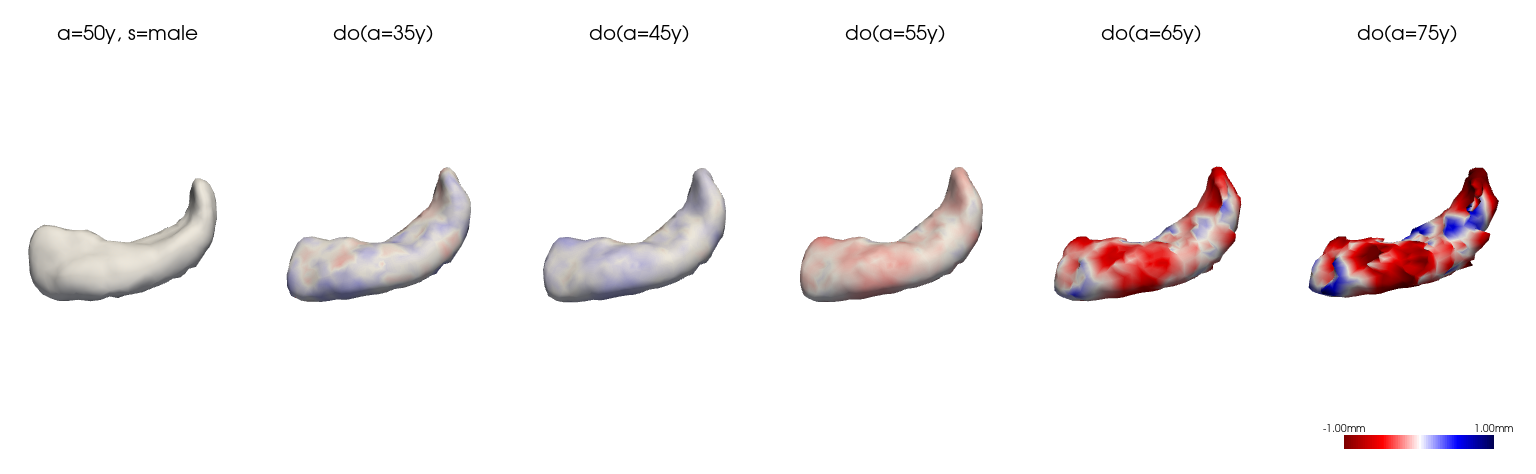

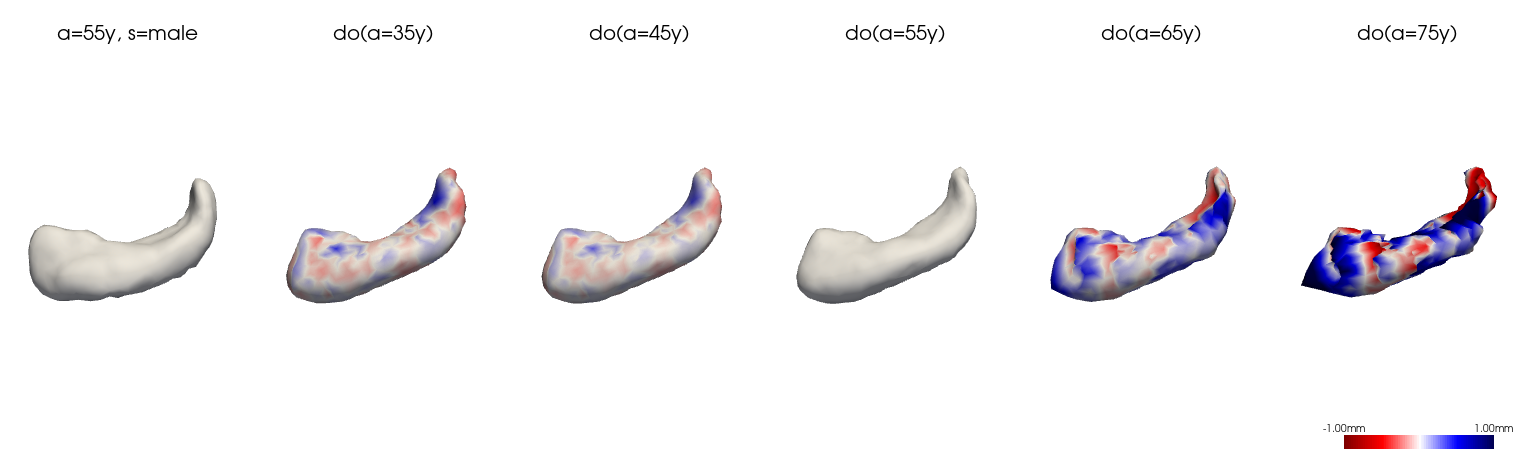

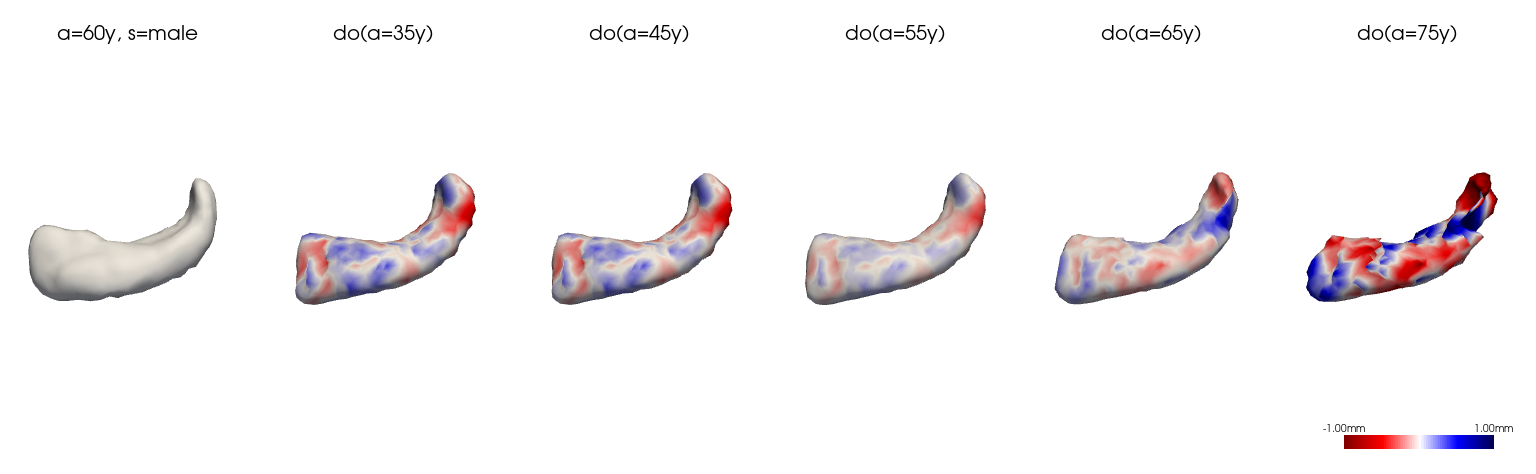

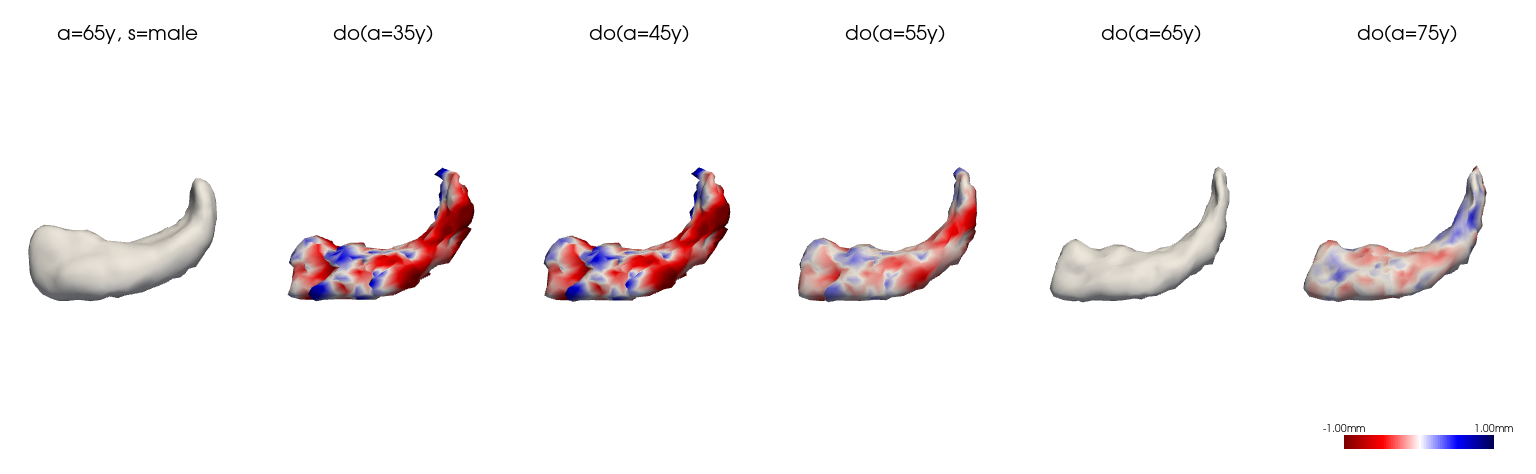

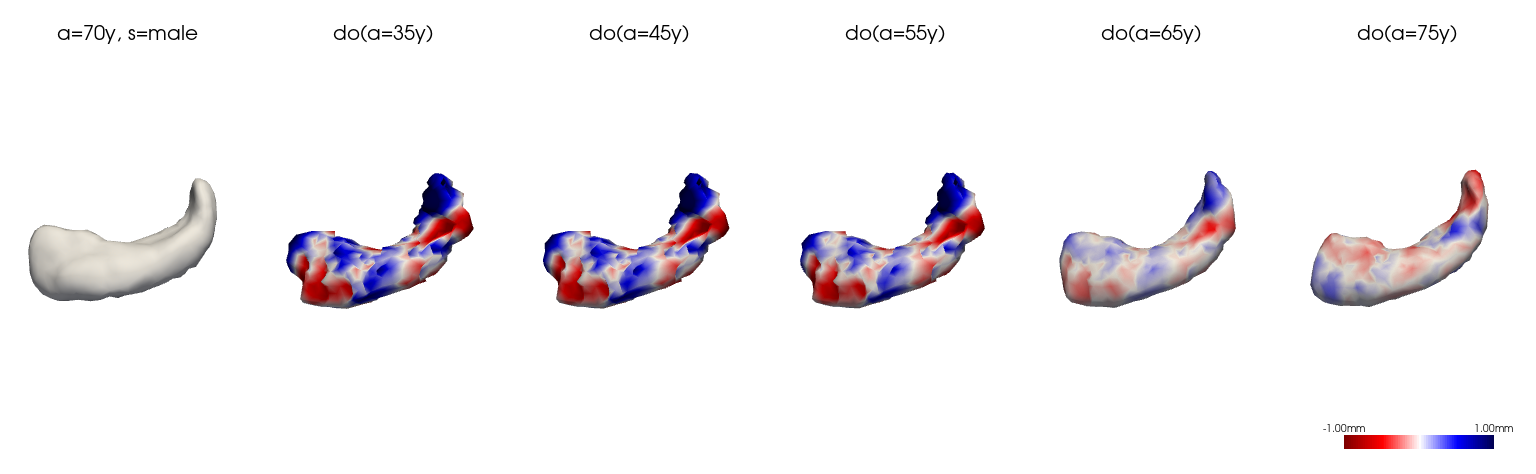

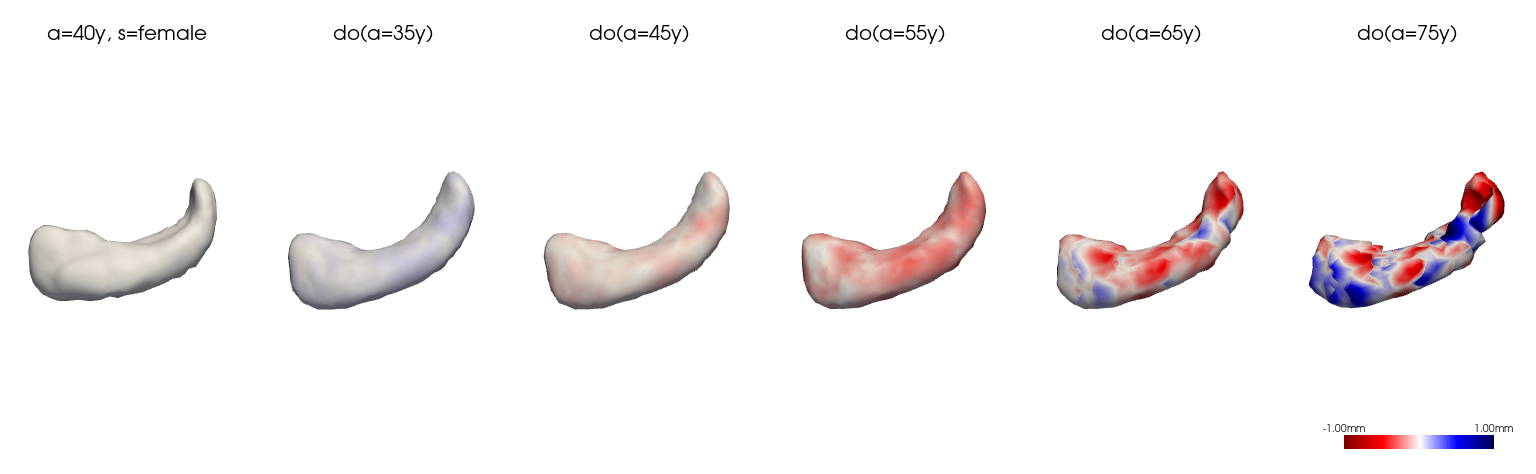

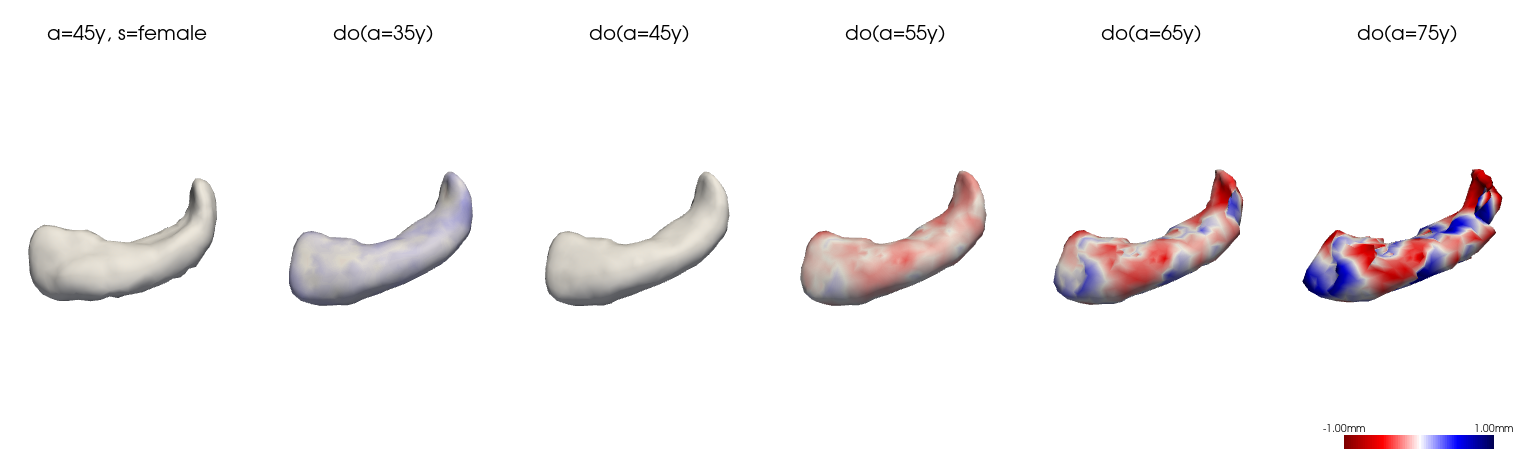

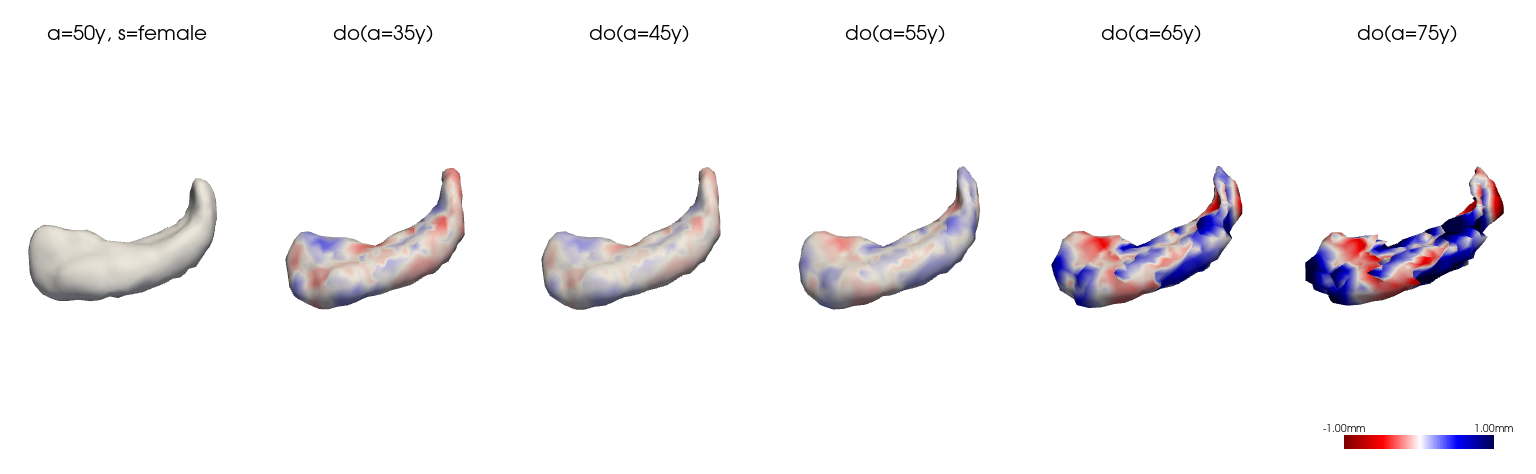

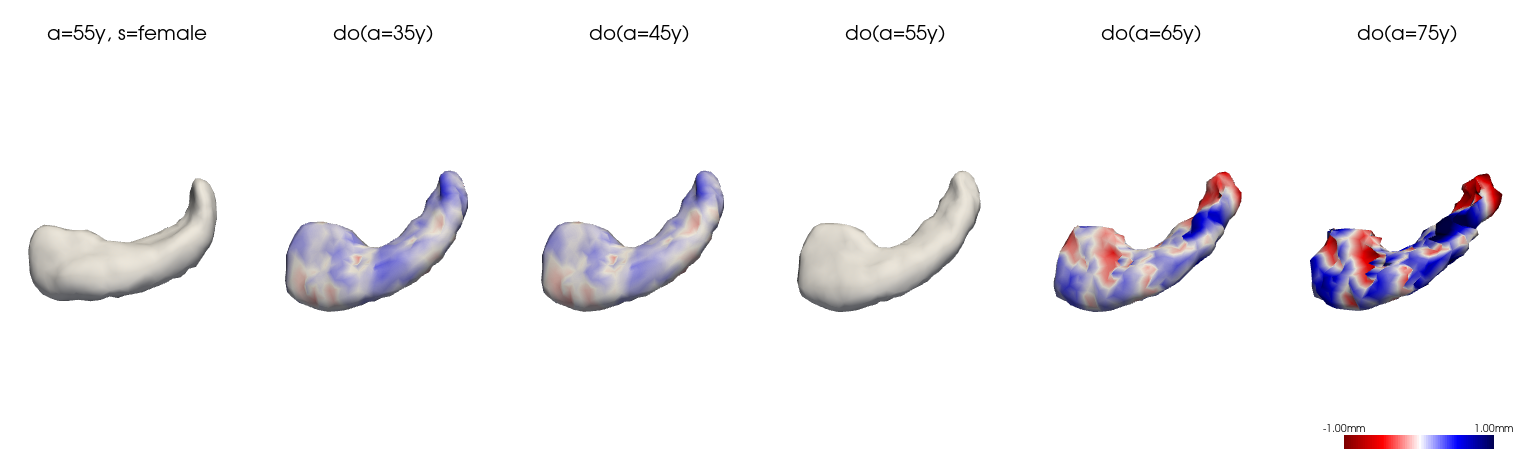

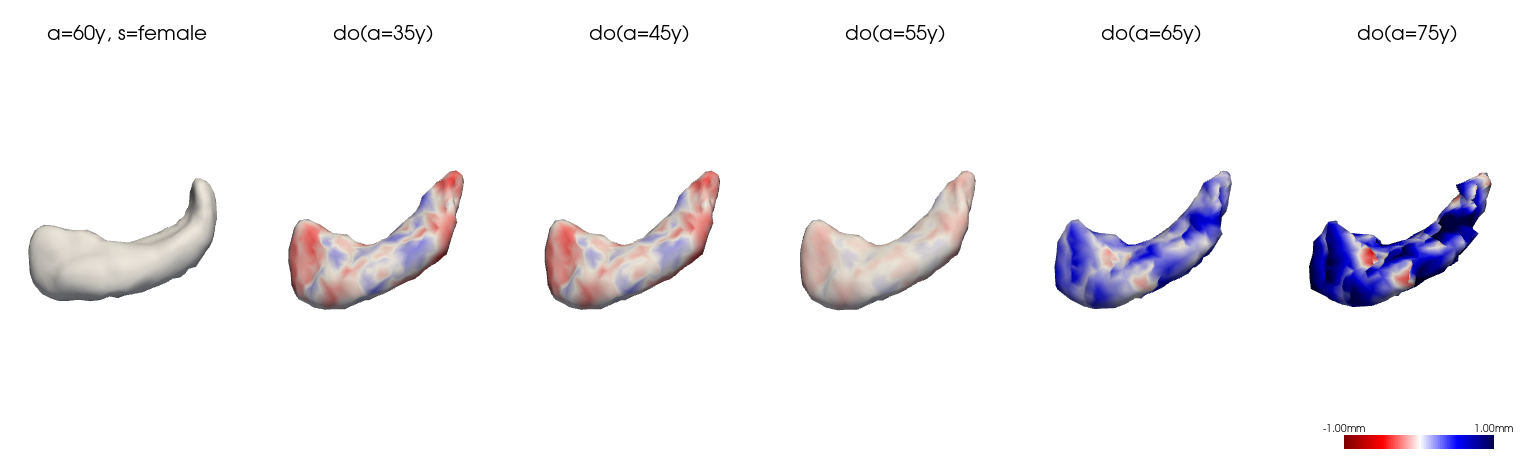

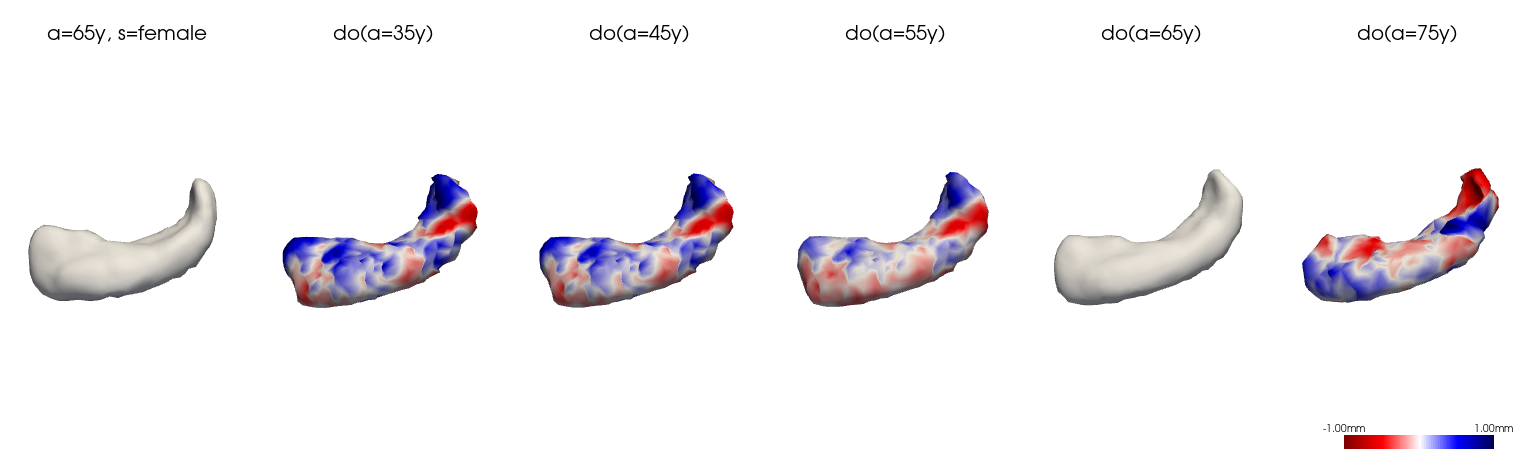

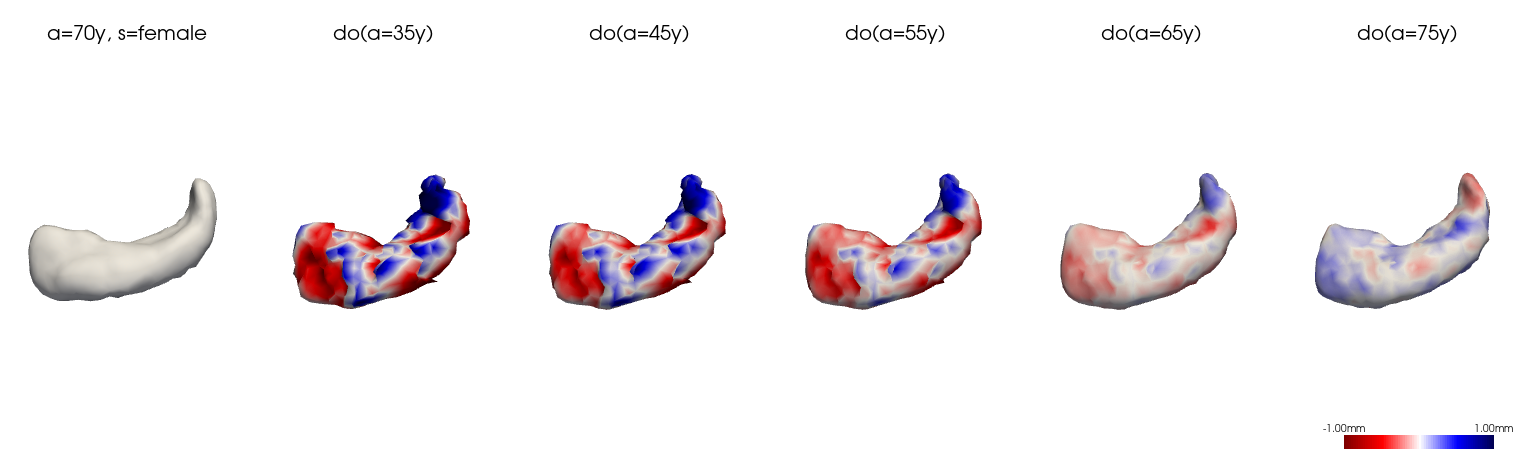

In [89]:
plot_counterfactuals(
    age_sex_samples, eids, all_inputs, all_age_interventions, hipp_template, 
    counterfactuals, [-1., 1.],
)

In [35]:
# all_inputs, eids = get_inputs_for_counterfactuals(
#     train_hipp_metadata_df, train_hipp_meshes, age_sex_samples
# )
# counterfactuals = get_counterfactuals(
#     age_sex_samples, all_inputs, all_sex_interventions, hipp_loaded_model,
# )
# plot_counterfactuals(
#     age_sex_samples, eids, all_inputs, all_age_interventions, hipp_template, 
#     counterfactuals, [-10.0, 10.0],
# )
# cfs['hipp']['training']['sex'] = counterfactuals

In [36]:
# all_inputs, eids = get_inputs_for_counterfactuals(
#     test_hipp_metadata_df, test_hipp_meshes, age_sex_samples
# )
# counterfactuals = get_counterfactuals(
#     age_sex_samples, all_inputs, all_age_interventions, hipp_loaded_model,
# )
# cfs['hipp']['testing']['age'] = counterfactuals

In [38]:
# all_inputs, eids = get_inputs_for_counterfactuals(
#     test_hipp_metadata_df, test_hipp_meshes, age_sex_samples
# )
# counterfactuals = get_counterfactuals(
#     age_sex_samples, all_inputs, all_sex_interventions, hipp_loaded_model,
# )
# cfs['hipp']['testing']['sex'] = counterfactuals

In [48]:
# np.save('cf_dict_v87_90', cfs)

In [55]:
# plot_counterfactuals(
#     age_sex_samples, eids, all_inputs, all_age_interventions, hipp_template, 
#     cfs_dict['hipp']['training']['age'], [-10.0, 10.0],
# )

## Combined Plots

In [14]:
# get means for each intervention category
# means with diffs on the top row
# 

In [10]:
def get_means_dict(meshes, series_age, interventions):
    means_dict = {}

    for _int in interventions:
        mask = _int == series
        if mask.sum():
            means_dict[_int] = meshes[mask].mean(axis=0)
        else:
            means_dict[_int] = None
            
    return means_dict

In [11]:
# cfs_dict = np.load('cf_dict_v87_90.npy', allow_pickle=True)[()]
all_age_interventions_list = [_int['age'] for _int in all_age_interventions[0]]
all_sex_interventions_list = [_int['sex'] for _int in all_sex_interventions[0]]
# stem_means_by_age = get_means_dict(
#     train_stem_meshes,
#     train_stem_metadata_df.age,
#     all_age_interventions_list
# )
# stem_means_by_sex = get_means_dict(
#     train_stem_meshes,
#     train_stem_metadata_df.sex,
#     all_sex_interventions_list
# )

In [157]:
cfs = np.load('cfs_all_brain_stem.npy', allow_pickle=True)[()]
cfs.keys()

dict_keys([87, 96, 95, 99])

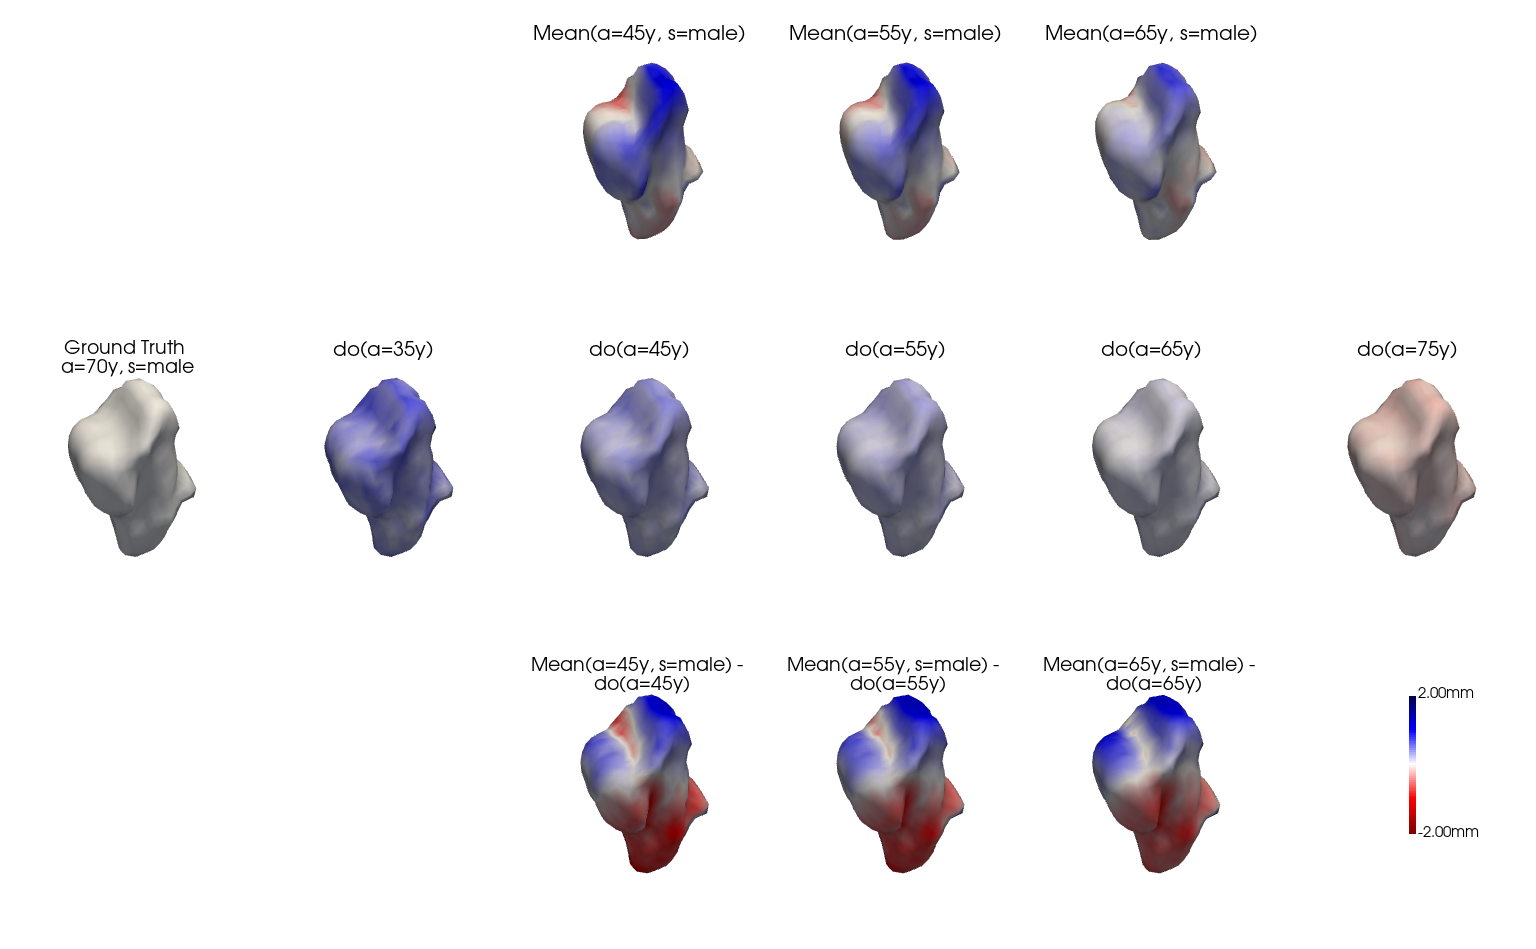

[(1.0, 1.0, 1.0),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [158]:
age_sex_pair = (70, 1)
_cfs_dict = cfs[99][age_sex_pair]  # cfs_dict['stem']['testing']['age'][age_sex_pair]

width = 768 * 2
height = int(width / 1.618)

rot = (0, 0, 240)

plotter = pv.Plotter(
    shape=(3, len(all_age_interventions_list) + 1),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)

_template = stem_template
_metadata_df = test_stem_metadata_df
_meshes = test_stem_meshes
_age = age_sex_pair[0]
_sex = age_sex_pair[1]
_clim = [-2., 2.]
_cmap = 'seismic'
_scalar = 'diff'

age_title = f'{var_name["age"]}={value_fmt["age"](str(_age))}' 
sex_title = f'{var_name["sex"]}={value_fmt["sex"](str(_sex))}'
title = f'Ground Truth \n{age_title}, {sex_title}'

def template_with_points(template, points):
    _template = template.copy()
    _template.points = points
    return _template

def rot_template(template, rot):
    template.rotate_x(rot[0])
    template.rotate_y(rot[1])
    template.rotate_z(rot[2])
    
def plot_mesh(x, y, title, mesh_arr, diff, template):
    plotter.subplot(x, y)
    plotter.add_title(title, font_size=8)
    mesh = template_with_points(template, mesh_arr)
    rot_template(mesh, rot)
    mesh['diff'] = diff
    plotter.add_mesh(
        mesh,
        scalars=_scalar,
        cmap=_cmap,
        clim=_clim,
        smooth_shading=True,
        flip_scalars=True,
        show_scalar_bar=False
    )

ground_truth_mesh = get_inputs_for_counterfactuals(_metadata_df, _meshes, [age_sex_pair])[0][0]['x']
ground_truth = template_with_points(_template, ground_truth_mesh)
rot_template(ground_truth, rot)
ground_truth['diff'] = np.zeros(_template.points.shape[0])

mask = (_metadata_df.age == _age) & (_metadata_df.sex == _sex)
_mean_mesh = _meshes[mask].mean(axis=0)

plotter.subplot(1, 0)
actor = plotter.add_title(title, font_size=8)
plotter.add_mesh(ground_truth, scalars=_scalar, cmap=_cmap, clim=_clim, smooth_shading=True, flip_scalars=True, show_scalar_bar=False)

for i, _age in enumerate(all_age_interventions_list):
    cf_mesh = _cfs_dict['imgs'][i].numpy()[0]
    diff = _cfs_dict['diffs'][i]
    plot_mesh(1, i + 1, f'do(a={int(_age)}y)', cf_mesh, diff, _template)
    
    mask = (_metadata_df.age == _age) & (_metadata_df.sex == _sex)
    
    if mask.sum():
        mean_mesh = _meshes[mask].mean(axis=0)
        diff = (-_mean_mesh + mean_mesh).mean(axis=1)
        plot_mesh(0, i + 1, f'Mean(a={int(_age)}y, {sex_title})', mean_mesh, diff, _template)
        diff = (-cf_mesh + mean_mesh).mean(axis=1)
        plot_mesh(2, i + 1, f'Mean(a={int(_age)}y, {sex_title}) - \n do(a={int(_age)}y)', cf_mesh, diff, _template)
        
plotter.subplot(2, len(all_age_interventions_list))
plotter.add_scalar_bar(
    label_font_size=15,
    position_x=0.5,
    position_y=0.35,
    title_font_size=20,
    shadow=True,
    n_labels=2,
    fmt='%.2fmm',
    vertical=True,
)

plotter.show()